O que é <b>BERT</b>?

<b>BERT</b> significa <b>B</b>idirectional <b>E</b>ncoder <b>R</b>epresentations from <b>T</b>ransformers.

<b>Bidirecional</b> - para entender o texto que estamos procurando, temos de olhar para trás (nas palavras anteriores) e para a frente (nas próximas palavras)

<b>Transformers</b> - O mecanismo de Atenção é tudo que precisamos. O Transformer lê sequências inteiras de tokens de uma vez. Em certo sentido, o modelo é não direcional, enquanto os LSTMs leem sequencialmente (da esquerda para a direita ou da direita para a esquerda). O mecanismo de atenção permite o aprendizado de relações contextuais entre palavras.

<b>Embeddings</b> de palavras contextualizadas (pré-treinadas) - O artigo ELMO apresentou uma maneira de codificar palavras com base em seu significado / contexto.

O BERT foi treinado mascarando 15% dos tokens com o objetivo de adivinhá-los. Um objetivo adicional era prever a próxima frase.

BERT é simplesmente uma stack pré-treinada de Transformer Encoders com duas versões 
- com 12 (BERT base) 
- com 24 (BERT Large).

A BERT pode ser utilizada em inúmeras tasks do NLP, aqui <b>tentaremos</b> utilizar para classificar se, dadas duas entidades e a sentença a qual elas pertencem, há uma relação semântica entre elas.

Importando as bibliotecas necessárias para rodar o modelo

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import os

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

Setando alguns parametros básicos

In [3]:
#Configurando parametros para visualização de dados
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#Configuração de SEED 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#Flag para utilizar cuda quando presente uma GPU ou utilizar CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Capturando os dados

In [10]:
pwd = os.path.join(os.getcwd(), 'data').replace("notebook\\","")
print(pwd)

data = pd.read_csv(os.path.join(pwd, 'input/data_full.csv'), sep=';').replace({np.NaN: None})
data.columns = ['sentenca','entidade1','entidade1_tipo','relacao','entidade2','entidade2_tipo']

data['class'] = data['relacao'].apply(lambda x: 0 if x is None else 1)
data.head()

D:\Mestrado\2020-02\Deep Learning\relation-extraction-deep-learning\data


,sentenca,entidade1,entidade1_tipo,relacao,entidade2,entidade2_tipo,class
0,A Kroton anunciou uma parceria com o Cubo Itaú...,Kroton,ORG,anunciou uma parceria com,Cubo Itaú,ORG,1
1,O evento Summit AgriHub reuniu nesta quinta-fe...,Summit AgriHub,ORG,reuniu em,Cuiabá,PLC,1
2,O evento Summit AgriHub reuniu nesta quinta-fe...,Summit AgriHub,ORG,None,Mato Grosso,PLC,0
3,O evento Summit AgriHub reuniu nesta quinta-fe...,Summit AgriHub,ORG,None,Brasil,PLC,0
4,"Ousuário consegue comparar prazos , condições ...",Bradesco,ORG,None,Banco do Brasil,ORG,0


Verificando como o dataset está populado.
Não informações nulas nos campos de Sentença, Entidade 1, Entidade 2 e Class

In [24]:
data = data.head(10)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
sentenca          10 non-null object
entidade1         10 non-null object
entidade1_tipo    10 non-null object
relacao           2 non-null object
entidade2         10 non-null object
entidade2_tipo    10 non-null object
class             10 non-null int64
dtypes: int64(1), object(6)
memory usage: 688.0+ bytes


Verificando o balanceamento de classes

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


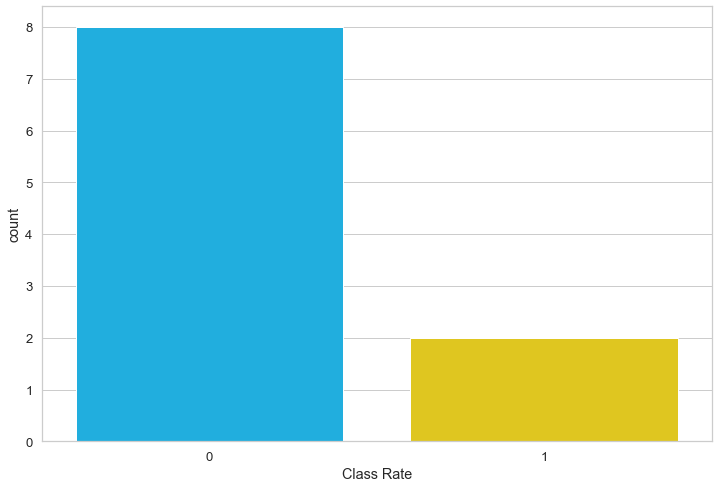

In [25]:
sns.countplot(data['class'])
plt.xlabel('Class Rate');

<h2>Pre-Processamento</h2>

É preciso converter texto em números. 
O BERT exige ainda mais atenção. Dessa maneira:

- Adicionaremos tokens especiais para separar frases e fazer a classificação
- Passaremos sequências de comprimento constante (introduzir preenchimento)
- Criaremos uma matriz de 0s (token de teclado) e 1s (token real) chamada máscara de atenção
- A biblioteca Transformers fornece vários modelos de Transformers (incluindo BERT). Funciona com TensorFlow e PyTorch! Também inclui tokenizers pré-construídos que fazem o trabalho pesado para nós!

Carregando o tokenizador pre-treinado da BERT

In [26]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-large-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Entendendo o que faz o tokenizador, pegando apenas uma sentença do corpus inteiro.

In [27]:
sentenca_amostra = data['sentenca'].iloc[0]
tokens = tokenizer.tokenize(sentenca_amostra)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'- Sentença: {sentenca_amostra}')
print(f'- Tokens: {tokens}')
print(f'- Token IDs: {token_ids}')

- Sentença: A Kroton anunciou uma parceria com o Cubo Itaú , que dará origem à vertical “Cubo Education” , um espaço dedicado ao fomento de edtechs – tecnologia aplicada à educação .
- Tokens: ['a', 'k', '##ro', '##ton', 'anunciou', 'uma', 'parceria', 'com', 'o', 'cub', '##o', 'it', '##au', ',', 'que', 'dar', '##a', 'origem', 'a', 'vertical', '“', 'cub', '##o', 'educa', '##tion', '”', ',', 'um', 'espa', '##co', 'dedicado', 'ao', 'fome', '##nto', 'de', 'ed', '##tec', '##h', '##s', '–', 'tecnologia', 'aplicada', 'a', 'educa', '##ca', '##o', '.']
- Token IDs: [123, 1396, 157, 897, 3127, 230, 4495, 170, 146, 13435, 22280, 21627, 1382, 117, 179, 2822, 22278, 2008, 123, 14357, 1112, 13435, 22280, 6974, 1131, 22354, 117, 222, 1632, 303, 8055, 320, 11062, 234, 125, 902, 8948, 22296, 22281, 1379, 4277, 11107, 123, 6974, 304, 22280, 119]


<h2> Tokens Especiais </h2>

[SEP] - Token que marca o fim da sentença.
('[SEP]', 102)

[CLS] - Token que marca o início da sentença.
('[CLS]', 101)

[PAD] - Token para preenchimento da sentença para que todas fiquem em um cumprimento fixo.
('[PAD]', 0)

[UNK] - Token para todos os tokens que a BERT desconhece
('[UNK]', 100)

<h2>Estabelecendo o comprimento da sentença</h2>

O BERT trabalha com sequências de comprimento fixo. 
Vamos armazenar o comprimento do token de cada avaliação e capturar o comprimento máximo

In [28]:
token_lens = []
for txt in data.sentenca:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    
MAX_LENGHT = max(token_lens)
print(MAX_LENGHT)

98


Histograma dos tokens

para visualizar a distribuição das sentenças em relação a distribuição dos tokens.

c:\users\daniel\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


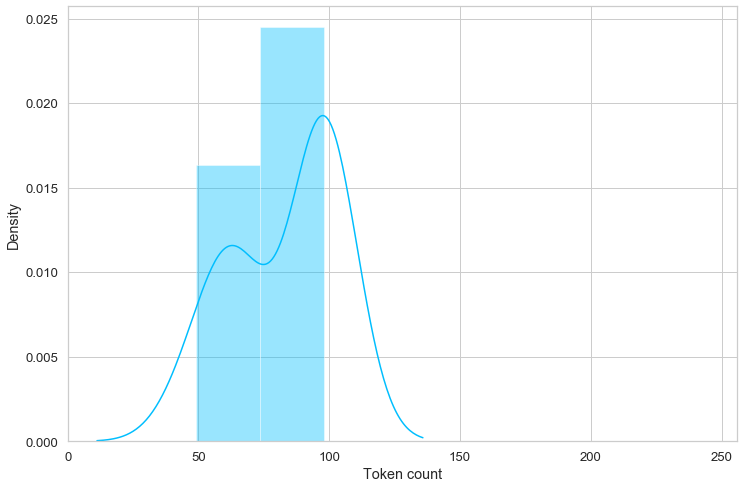

In [29]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

<h2>Classe de pré-processamento</h2>
    
Temos todos os blocos de construção necessários para criar um conjunto de dados PyTorch. Isso será feito a partir de uma classe estabelecida abaixo.

O tokenizer está fazendo a maior parte do trabalho. Também devolve a sentença que foi classificada, para que seja mais fácil avaliar as previsões do modelo. 

In [30]:
#TODO Fazer a passagem das entidades como parametro para concatenar os vetores delas ao vetor da sentença
class preProccesDataset(Dataset):
    
    def __init__(self, data, targets, tokenizer, max_len):
        self.sentence = data
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentence)
    
    def __getitem__(self, item):
        review = str(self.sentence[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=True,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

<h2>Separação dos dados</h2>
Treino, Teste e Validação

Dividindo os dados entre treino (x%) e teste (y%), onde x+y = 100

Em seguida, divide os dados de teste entre teste (x%) e validação (y%), onde x+y = 100

In [49]:
df_train, df_test = train_test_split(
  data,
  test_size=0.2,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_test.shape, df_val.shape

((8, 7), (1, 7), (1, 7))

<h2>Data Loader </h2>
Função que auxilia na criação dos dataloaders dos dados utilizando a classe recém criada de processamento de sentenças.

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = preProccesDataset(
        data=df['sentenca'].to_numpy(),
        targets=df['class'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
  )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
  )

BATCH_SIZE = 16

Criando os data loaders para cada função de dataset

In [52]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGHT, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGHT, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGHT, BATCH_SIZE)

Exemplo do data loader de treinamento:

In [67]:
df = next(iter(train_data_loader))
print(df.keys())

print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 98])
torch.Size([8, 98])
torch.Size([8])


Carregando o modelo pré-treinado BERT

In [69]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

<h2>Modelo Classificador</h2>

Criando um classificador que use o modelo <b>BERT</b>:

O classificador delega a maior parte do trabalho pesado para o BertModel. Usamos uma camada de eliminação para alguma regularização e uma camada totalmente conectada para nossa saída. 

Retorna a saída bruta da última camada, pois isso é necessário para que a função de perda de entropia cruzada em PyTorch funcione.

In [55]:
class ModeloVerificaRelacao(nn.Module):
    
    def __init__(self, n_classes):
        super(ModeloVerificaRelacao, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
    )
    
        output = self.drop(pooled_output)
        return self.out(output)

Criando uma instância e movê-la para a GPU <b>(caso tenha)</b>

In [70]:
NUM_CLASSES = 2

model = ModeloVerificaRelacao(NUM_CLASSES)
model = model.to(device)

Lote de exemplo de nossos dados de treinamento movido para a GPU:

In [72]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 98])
torch.Size([8, 98])


<h2>Treinamento</h2>

Para reproduzir o procedimento de treinamento do artigo de BERT, usamos o otimizador AdamW fornecido por Hugging Face. Ele corrige a deterioração do peso. Também usaremos um agendador linear sem etapas de warmup:

In [73]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

De onde são esses hiperparâmetros? Os autores do BERT têm algumas recomendações para o ajuste fino:

- Tamanho do lote: 16, 32
- Taxa de aprendizagem (Adam): 5e-5, 3e-5, 2e-5
- Número de épocas: 2, 3, 4
- Vamos ignorar a recomendação do número de épocas, mas ficar com o resto. Observe que aumentar o tamanho do lote reduz significativamente o tempo de treinamento, mas oferece menor precisão.

Função auxiliar para treinar o modelo para uma época:

In [59]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

O treinamento do modelo deve parecer familiar, exceto por duas coisas. O scheduler é chamado sempre que um lote é alimentado para o modelo. A explosão de gradientes está sendo evitada recortando os gradientes do modelo usando <i><b>clipgrad_norm</b></i>.

Outra função para avaliar o modelo em um determinado data loader:

In [60]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Usando essas duas funções, temos o loop de treinamento. 
Também armazenaremos o histórico de treinamento:

In [61]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
  
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
  
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8183591961860657 accuracy 0.25
Val   loss 0.24821095168590546 accuracy 1.0

Epoch 2/10
----------
Train loss 0.4063939154148102 accuracy 0.875
Val   loss 0.09371846914291382 accuracy 1.0

Epoch 3/10
----------
Train loss 0.26584339141845703 accuracy 0.875
Val   loss 0.0553746335208416 accuracy 1.0

Epoch 4/10
----------
Train loss 0.2336919605731964 accuracy 0.875
Val   loss 0.021607233211398125 accuracy 1.0

Epoch 5/10
----------
Train loss 0.2137945294380188 accuracy 0.875
Val   loss 0.01451821718364954 accuracy 1.0

Epoch 6/10
----------
Train loss 0.1781088411808014 accuracy 0.875
Val   loss 0.011928535997867584 accuracy 1.0

Epoch 7/10
----------
Train loss 0.07817644625902176 accuracy 1.0
Val   loss 0.009494861587882042 accuracy 1.0

Epoch 8/10
----------
Train loss 0.05690765380859375 accuracy 1.0
Val   loss 0.007324981968849897 accuracy 1.0

Epoch 9/10
----------
Train loss 0.04107761010527611 accuracy 1.0
Val   loss 0.006059845443814993 accur

O estado do melhor modelo é armazenado, indicado pela maior precisão de validação.

É possível observar a precisão do treinamento vs validação: